In [1]:
import os

os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from urbanstats.games.quiz import compute_fractional_days
from urbanstats.games.quiz_analysis import get_full_statistics, questions

/home/kavi/anaconda3/envs/urbanstats/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
plt.rcParams["font.family"] = "monospace"

In [5]:
today = int(compute_fractional_days("America/New_York"))

In [6]:
result = get_full_statistics(after_problem=49, debug=False)

In [7]:
def plot_juxtastat_times(compute_y, formatter=lambda x: f"{x:.0f}%", dx=0.5):
    plt.figure(dpi=200, facecolor="white")
    pre_today = result[(result.problem < today) & (result.last_in_batch == 1)].copy()
    time_all = pre_today.offset
    weights = 1 / pre_today.groupby("problem").count().user_id[pre_today.problem]
    weights /= weights.sum()
    pre_today["weight"] = list(weights)
    bins = np.arange(-14, 28 + dx, dx)
    y = []
    for xs, xe in zip(bins[:-1], bins[1:]):
        tab = pre_today[(xs <= pre_today.offset) & (pre_today.offset < xe)]
        y += [compute_y(tab)]
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array(y)
    ymax = np.nanmax(y)
    # x, y = line_histogram(time_all, weights=100 * weights, dx=0.5)
    plt.plot(x, y, lw=0.5, marker=".", color="black")
    plt.xlabel("Time in day [EDT]")
    plt.xticks([-12, -6, 0, 6, 12, 18, 24, 6])

    def span(s, e, color, name):
        plt.axvspan(s, e, alpha=0.5, color=color)
        count = compute_y(pre_today[(s <= time_all) & (time_all < e)])
        format_count = formatter(count)
        plt.text(
            x=(s + e) / 2, y=ymax * 1.1, s=f"{name}\n({format_count})", ha="center"
        )

    span(-14, 0, "#f96d6d", "Non_US")
    span(0, 6, "#5a7dc3", "Night")
    span(6, 18, "#8ac35a", "Day")
    span(18, 28, "#4e525a", "Last Minute")

    plt.ylim(0, ymax * 1.3)
    plt.grid()

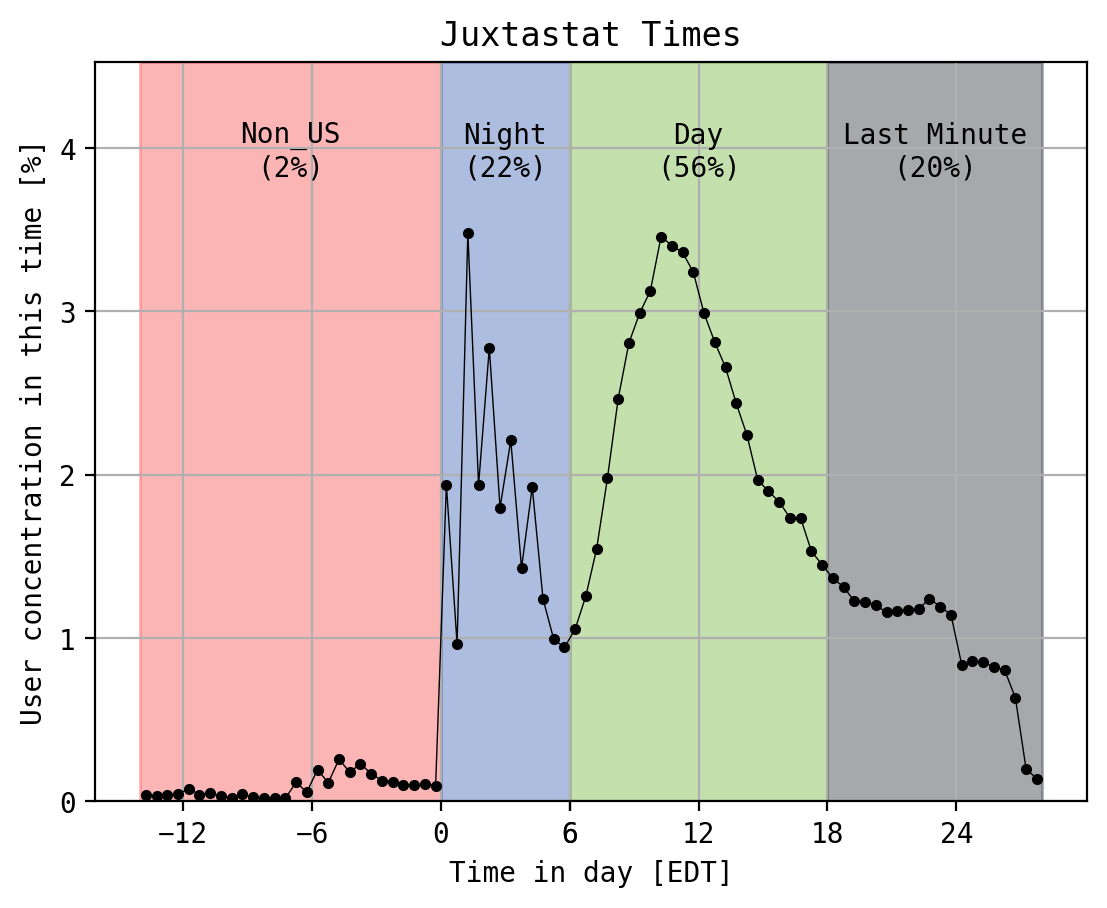

In [8]:
plot_juxtastat_times(compute_y=lambda tab: tab["weight"].sum() * 100)
plt.title("Juxtastat Times")
plt.ylabel("User concentration in this time [%]")
plt.show()

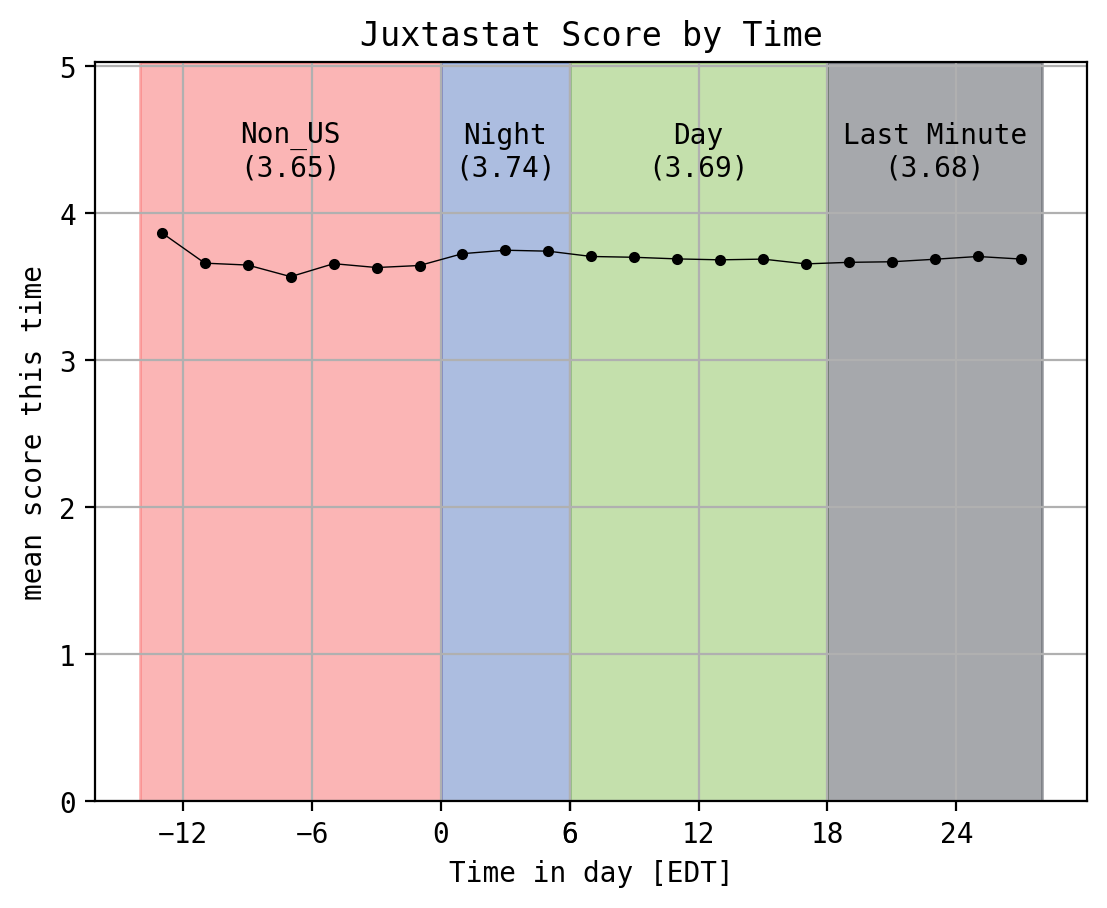

In [9]:
plot_juxtastat_times(
    compute_y=lambda tab: (tab["weight"] * tab["score"]).sum() / tab["weight"].sum()
    if tab["weight"].sum()
    else np.nan,
    formatter=lambda x: f"{x:.2f}",
    dx=2,
)
plt.title("Juxtastat Score by Time")
plt.ylabel("mean score this time")
plt.show()